# ML in Bioinf, Assignment Week 11, Team C
## Random Forest Classifier

In [1]:
%pylab inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn import preprocessing, metrics
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pyopenms
from pyopenms import *
import glob

Populating the interactive namespace from numpy and matplotlib


## Load the data files

In [2]:
df_samples = pd.read_csv('MTBLS946 dataset_combinedData.csv', index_col=0, header=None)
df_samples.columns = list(df_samples.iloc[0][:6].values) + list(df_samples.iloc[1][6:].values)
df_samples = df_samples.iloc[10:,5:]
df_samples.head()

,Class,34.07_101.5536m/z,48.12_101.5536m/z,62.17_101.5536m/z,76.22_101.5536m/z,104.31_101.5536m/z,132.41_101.5536m/z,146.46_101.5536m/z,174.56_101.5536m/z,188.6_101.5536m/z,...,48.12_1176.8275m/z,160.51_1176.8275m/z,315.04_1176.8275m/z,385.28_1176.8275m/z,511.72_1176.8275m/z,525.77_1176.8275m/z,652.2_1176.8275m/z,160.51_1188.775m/z,343.14_1188.775m/z,385.28_1188.775m/z
0,,,,,,,,,,,,,,,,,,,,,
0,Pre Surgery,246789600.0,151316721.0,0.0,1176513.0,0.0,0.0,15479740.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Pre Surgery,263863696.0,110987854.0,8541313.0,0.0,0.0,0.0,435721216.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Pre Surgery,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Pre Surgery,0.0,0.0,28651260.0,11691700.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5987805.0,1289856.0,0.0,0.0,0.0,0.0
4,Pre Surgery,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8513482.0,0.0,0.0,0.0,18257548.33333333,1054407.0,1485541.0


## Preprocess the labels to 0 for Pre Surgery and 1 for Post Surgery

In [3]:
# get the data out of the methylationarray object, encode the cancer/normal values to 1/0
Y = pd.Series([0 if v == "Pre Surgery" else 1 if v == "Post Surgery" else 2 for v in df_samples["Class"]])
X = df_samples.drop(["Class"], axis=1)

Train_X, Test_X, Train_Y, Test_Y = train_test_split(
    X, Y, test_size=0.3, random_state=42)

# append validation to test set because we use cross validation
print("Train Shape: ",Train_X.shape)
print("Test Shape: ",Test_X.shape)

Train Shape:  (11, 5513)
Test Shape:  (5, 5513)


In [4]:
# Fix random seed for reproducibility
seed = 3
# np.random.seed(seed)

In [5]:
# Set parameters
clf = RandomForestClassifier(n_estimators=100, random_state=seed)

In [6]:
# Set parameters for cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

## Get the training accuracy and AUC using kfold cross-validation

In [7]:
probabilities = cross_val_predict(clf, Train_X, Train_Y, cv=kfold, method='predict_proba')

In [8]:
def predict_classes(probabilities):
    """Predict class labels from probabilities"""
    
    predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])
    label_binarizer = preprocessing.LabelBinarizer()
    label_binarizer.fit(range(max(predicted) + 1))
    return label_binarizer.transform(predicted)

In [9]:
print('Cross validation accuracy:')
print(metrics.accuracy_score(Train_Y, predict_classes(probabilities)))
print('\nCross validation classification report\n')
print(metrics.classification_report(Train_Y, predict_classes(probabilities)))
tn, fp, fn, tp = metrics.confusion_matrix(Train_Y, predict_classes(probabilities)).ravel()
print('\nSensitivity: ',tp / (tp+fn))
print('\nSpecificity: ',tn / (tn+fp))

Cross validation accuracy:
0.8181818181818182

Cross validation classification report

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.78      1.00      0.88         7

    accuracy                           0.82        11
   macro avg       0.89      0.75      0.77        11
weighted avg       0.86      0.82      0.80        11


Sensitivity:  1.0

Specificity:  0.5


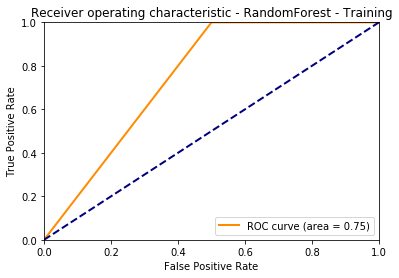

In [18]:
# Plot ROC
fpr, tpr, thresholds = metrics.roc_curve(Train_Y, predict_classes(probabilities))
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - RandomForest - Training')
plt.legend(loc="lower right")
plt.show()

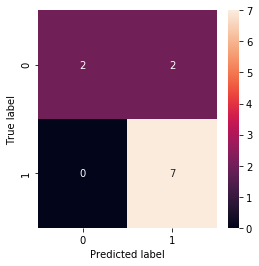

In [12]:
# Plot confusion matrix
confusion_matrix = metrics.confusion_matrix(Train_Y, predict_classes(probabilities))
class_names = sorted(Train_Y.unique())
df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
fig = plt.figure(figsize=(4,4))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Show the 18 most important features

In [13]:
# Rebuild model
clf_fit = clf.fit(Train_X, Train_Y)

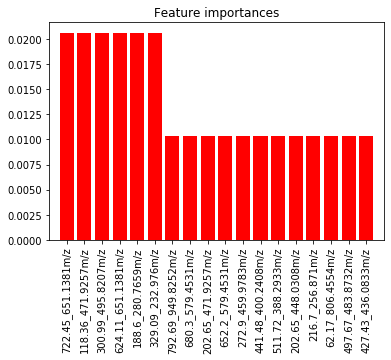

The 18 most important features are: 

Index(['722.45_651.1381m/z', '118.36_471.9257m/z', '300.99_495.8207m/z',
       '624.11_651.1381m/z', '188.6_280.7659m/z', '329.09_232.976m/z',
       '792.69_949.8252m/z', '680.3_579.4531m/z', '202.65_471.9257m/z',
       '652.2_579.4531m/z', '272.9_459.9783m/z', '441.48_400.2408m/z',
       '511.72_388.2933m/z', '202.65_448.0308m/z', '216.7_256.871m/z',
       '62.17_806.4554m/z', '497.67_483.8732m/z', '427.43_436.0833m/z'],
      dtype='object')


In [14]:
# Create function to determine the feature importance 
importances = clf_fit.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(18),importances[indices][:18],color="r", align="center")
plt.xticks(range(18),Train_X.T.index[indices][:18],rotation = 90)
plt.xlim([-1, 18])
plt.show()
print('The 18 most important features are: \n')
print(Train_X.T.index[indices][:18])

## Get the test data accuracy and AUC

In [15]:
# Determine performance on test set
test_prob = clf_fit.predict_proba(Test_X)

In [16]:
# Metrics for test set
print('Cross validation accuracy:')
print(metrics.accuracy_score(Test_Y, predict_classes(test_prob)))
print('\nCross validation classification report\n')
print(metrics.classification_report(Test_Y, predict_classes(test_prob)))
tn, fp, fn, tp = metrics.confusion_matrix(Test_Y, predict_classes(test_prob)).ravel()
print('\nSensitivity: ',tp / (tp+fn))
print('\nSpecificity: ',tn / (tn+fp))

Cross validation accuracy:
0.8

Cross validation classification report

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.67      1.00      0.80         2

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5


Sensitivity:  1.0

Specificity:  0.6666666666666666


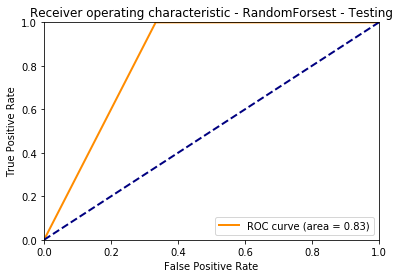

In [17]:
# Plot ROC
fpr, tpr, thresholds = metrics.roc_curve(Test_Y, predict_classes(test_prob))
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - RandomForsest - Testing')
plt.legend(loc="lower right")
plt.show()

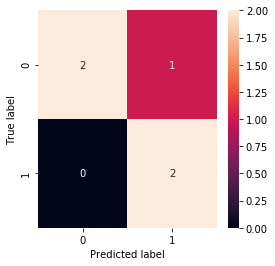

In [19]:
# Plot confusion matrix
confusion_matrix = metrics.confusion_matrix(Test_Y, predict_classes(test_prob))
class_names = sorted(Test_Y.unique())
df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
fig = plt.figure(figsize=(4,4))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Get testing accuracy again using feature selection of "r" features

In [20]:
# takes a while
maxtrain = 0
maxtest = 0
maxr = 0
for r in range(1, 50, 1):
    Train_X_select = np.take(Train_X, indices[:r], 1)
    clf_fit_select = clf.fit(Train_X_select, Train_Y)
    probabilities_select = cross_val_predict(clf, Train_X_select, Train_Y, cv=kfold, method='predict_proba')
    acctrain = metrics.accuracy_score(Train_Y, predict_classes(probabilities_select))
    Test_X_select = np.take(Test_X, indices[:r], 1)
    test_prob_select = clf_fit_select.predict_proba(Test_X_select)
    acctest =  metrics.accuracy_score(Test_Y, predict_classes(test_prob_select))
    if acctrain > maxtrain:
        if acctest > maxtest:
            maxtrain = acctrain 
            maxtest = acctest
            maxr = r
print(maxr)

1


In [21]:
r = 1

In [22]:
print('Themost important features are: \n')
for i in range(r):
    print(Train_X.T.index[indices][i], "Importance: {:.6f}".format(importances[indices][i]))

Themost important features are: 

722.45_651.1381m/z Importance: 0.020619


In [23]:
# Rebuild model
Train_X_select = np.take(Train_X, indices[:r], 1)
clf_fit_select = clf.fit(Train_X_select, Train_Y)

In [24]:
#Print accuracy
probabilities_select = cross_val_predict(clf, Train_X_select, Train_Y, cv=kfold, method='predict_proba')
print('Cross validation accuracy:')
print(metrics.accuracy_score(Train_Y, predict_classes(probabilities_select)))
print('\nCross validation classification report\n')
print(metrics.classification_report(Train_Y, predict_classes(probabilities_select)))
tn, fp, fn, tp = metrics.confusion_matrix(Train_Y, predict_classes(probabilities_select)).ravel()
print('\nSensitivity: ',tp / (tp+fn))
print('\nSpecificity: ',tn / (tn+fp))

Cross validation accuracy:
0.8181818181818182

Cross validation classification report

              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.86      0.86      0.86         7

    accuracy                           0.82        11
   macro avg       0.80      0.80      0.80        11
weighted avg       0.82      0.82      0.82        11


Sensitivity:  0.8571428571428571

Specificity:  0.75


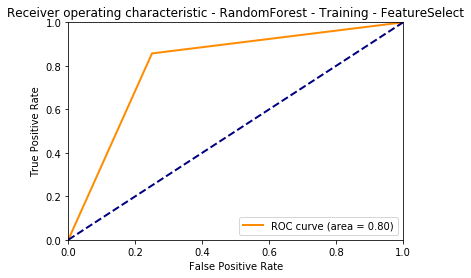

In [26]:
# Plot ROC
fpr, tpr, thresholds = metrics.roc_curve(Train_Y, predict_classes(probabilities_select))
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - RandomForest - Training - FeatureSelect')
plt.legend(loc="lower right")
plt.show()

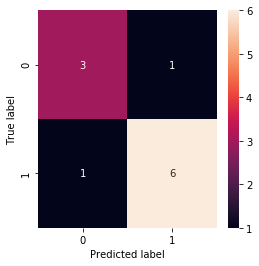

In [27]:
# Plot confusion matrix
confusion_matrix = metrics.confusion_matrix(Train_Y, predict_classes(probabilities_select))
class_names = sorted(Train_Y.unique())
df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
fig = plt.figure(figsize=(4,4))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Evaluate the feature reduced performance on the test set

In [28]:
# Determine performance on test set
Test_X_select = np.take(Test_X, indices[:r], 1)
test_prob_select = clf_fit_select.predict_proba(Test_X_select)

In [29]:
# Metrics for test set
print('Cross validation accuracy:')
print(metrics.accuracy_score(Test_Y, predict_classes(test_prob_select)))
print('\nCross validation classification report\n')
print(metrics.classification_report(Test_Y, predict_classes(test_prob_select)))
tn, fp, fn, tp = metrics.confusion_matrix(Test_Y, predict_classes(test_prob_select)).ravel()
print('\nSensitivity: ',tp / (tp+fn))
print('\nSpecificity: ',tn / (tn+fp))

Cross validation accuracy:
0.8

Cross validation classification report

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.67      1.00      0.80         2

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5


Sensitivity:  1.0

Specificity:  0.6666666666666666


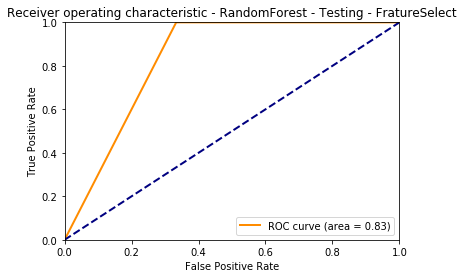

In [30]:
# Plot ROC
fpr, tpr, thresholds = metrics.roc_curve(Test_Y, predict_classes(test_prob_select))
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - RandomForest - Testing - FratureSelect')
plt.legend(loc="lower right")
plt.show()

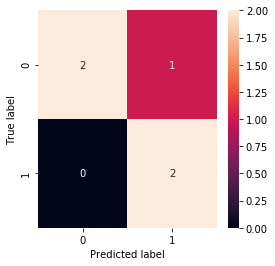

In [31]:
# Plot confusion matrix
confusion_matrix = metrics.confusion_matrix(Test_Y, predict_classes(test_prob_select))
class_names = sorted(Test_Y.unique())
df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
fig = plt.figure(figsize=(4,4))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()